# 填充和步幅

### 填充padding
- 通常使用小卷积核，对于单个卷积，可能只丢失几个像素；但是应用多层卷积时，常常**丢失边缘像素**，则会丢失很多有用信息
- 给定$(32\times32)$输入图像，应用$5\times5$大小的卷积核
    - 第1层得到输出大小$28\times28$
    - 第7层得到的输出大小$4\times4$
- **更大的卷积核**可以**更快地减小**输出大小
    - 形状从 $n_k \times n_w$ 减少到$(n_k-k_h+1) \times (n_w-k_w+1)$
#### **在输入周围添加额外的行/列**
- 填充$p_h$行和$p_w$列，输出形状为$(n_h-k_h+p_h+1) \times (n_w-k_w+p_w+1)$
    - **通常取**$p_h=k_h-1$，$p_w=k_w-1$ (核的高、宽-1)——**输出形状和输入形状相同**
        - 当$k_h$为奇数：在上下两侧填充$p_h/2$
        - 当$k_h$为偶数(很少)：在上侧填充$\left\lceil p_h/2 \right\rceil $在下侧填充 $\left\lfloor p_h/2 \right\rfloor $ (上侧多一行，下侧少一行；反过来也无所谓)
- 填充减小的输出大小与层数线性相关

### 步幅strides
- 给定$(224\times224)$输入图像，应用$5\times5$大小的卷积核，需要55层得到输出大小$4\times4$
    - 需要大量的计算才能得到较小输出
#### **步幅是指行/列的滑动步长**
- 给定高度 $ s_h $ 和宽度 $ s_w $ 的步幅，输出形状是（向下取整）
$$
  \left\lfloor \frac{(n_h - k_h + p_h + s_h)}{s_h} \right\rfloor \times \left\lfloor \frac{(n_w - k_w + p_w + s_w)}{s_w} \right\rfloor
$$

- 如果$ p_h = k_h - 1$，$ p_w = k_w - 1 $ （向下取整）
$$
  \left\lfloor \frac{(n_h + s_h - 1)}{s_h} \right\rfloor \times \left\lfloor \frac{(n_w + s_w - 1)}{s_w} \right\rfloor
$$

- 如果输入高度和宽度可以被步幅整除
$$
  \left(\frac{n_h}{s_h}\right) \times \left(\frac{n_w}{s_w}\right)
$$

### 总结
- **填充**和**步幅**是卷积层的**超参数**
- 填充在输入周围添加额外的行/列，来**控制输出形状的减少量**
    - 常用使得输入和输出具有相同的高和宽
- 步幅是每次滑动核窗口时的行/列的步长，可以**成倍的减少输出形状**

## 代码

**在所有侧边填充1个像素**
- 使得输出形状不变，则需要添加2行/列，那就是每侧加1行/列

In [5]:
import torch

from torch import nn

# 定义了一个计算卷积层的函数
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1) 
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

**填充不同的高度和宽度**

In [7]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

**将高度和宽度的步幅设置为2**

In [8]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

**一个稍微复杂的例子**

In [9]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 练习
1. 在本节中的实验中，试一试其他填充和步幅组合

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=(2, 3), stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([5, 6])

2. 对于音频信号，步幅$2$说明什么？
3. 步幅大于1的计算优势是什么？
- 减小计算量，减小内存占用，提高模型的泛化能力

### 注意：
- 超参数：**核**的大小通常是**最关键**的，**填充**一般是**默认**的——核的大小-1，**步幅**则**取决于模型**
- 卷积核一般都是取$3\times3$，多一个少一个其实效果大差不差
- 一般就是用经典的网络结构，很少自己去设计神经网络

# 多个输入和输出通道

### 多个输入通道
- 彩色图像可能有RGB三个通道，转为灰度会丢失信息
- 每个通道都有一个卷积核，结果是所有通道卷积结果的**和**
    - 输入$X$:$c_i \times n_h \times n_w$
    - 核$W$:$c_i \times k_h \times k_w$
    - 输出$Y$:$m_h \times m_w$
    - $\mathbf{Y} = \sum_{i=0}^{c_i} \mathbf{X}_{i,:,:} \star \mathbf{W}_{i,:,:}$

### 多个输出通道
- 可以有多个三维卷积核，每个核生成一个输出通道
    - 输入$X$:$c_i \times n_h \times n_w$
    - 核$W$:$c_o \times c_i \times k_h \times k_w$
    - 输出$Y$:$c_o \times m_h \times m_w$
    - $\mathbf{Y}_{i,:,:} = \mathbf{X} \star \mathbf{W}_{i,:,:,:} \quad \text{for } i = 1, \dots, c_o$
- 现实中，每个通道不是独立学习的，而是为了共同使用而优化的

### 多个输入和输出通道
- 每个输出通道可以**识别特定模型**
- 输入通道核识别并组合输入中的模式

### $1\times1$卷积层
$k_h=k_w=1$是一个受欢迎的选择
- **不识别空间模式，只是融合通道**
- **相当于**输入形状为$n_hn_w \times c_i$，权重为$c_o \times c_i$的**全连接层**
- 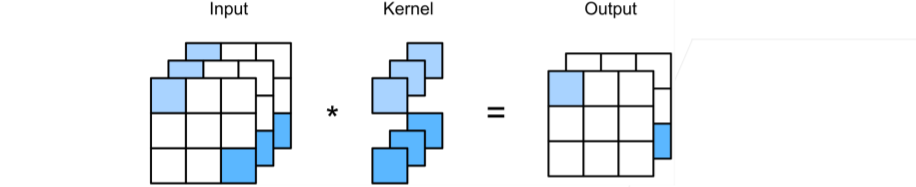
- $1\times1$卷积层通常用于调整网络层的通道数量和控制模型复杂性

### 二维卷积层
- 输入$X$:$c_i \times n_h \times n_w$
- 核$W$:$c_o \times c_i \times k_h \times k_w$
- 偏差$B$:$c_o \times c_i$
- 输出$Y$:$c_o \times m_h \times m_w$
- $$\mathbf{Y} = \mathbf{X} \star \mathbf{W} + \mathbf{B}$$
- 计算复杂度（浮点计算数FLOP）$\mathbf{O}(c_ic_ok_hk_wm_hm_w)$
    - $c_i=c_o=100$,$k_h=k_w=5$,$m_h=m_w=64$
    - $1GFLOP$
- 10层，1M样本，10PFLOPS（CPU:0.15TF=18H, GPU:12TF=14min）仅前向forward

### 总结
- **输出通道数**是卷积层的**超参数**
- 每个**输入**通道有独立的**二维**卷积核，**所有通道结果相加**得到**一个**输出通道结果
- 每个**输出**通道有独立的**三维**卷积核

## 代码

**实现一下多输入通道互相关运算**

In [12]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

**验证互相关运算的输出**

In [13]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

**计算多个通道的输出的互相关函数**
- `torch.stack(tensors, dim=0)`用于沿新维度对一组张量进行拼接
    - 与`torch.cat`不同的是，`torch.stack`会在拼接时**创建一个新的维度**
    - `dim=0`：新维度插入的位置

In [14]:
def corr2d_multi_in_out(X, k):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
print(K.shape)

corr2d_multi_in_out(X, K)

torch.Size([3, 2, 2, 2])


tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

**实现 $1\times1$ 卷积**

In [17]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))  # 将高、宽拉成一条向量
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [18]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [22]:
Y_1 = corr2d_multi_in_out_1x1(X, K)
Y_2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y_1 - Y_2).sum()) < 1e-6

### 练习
1. 假设我们有两个卷积核，大小分别为$k_1$和$k_2$（中间没有非线性激活函数）。
    1. 证明运算可以用单次卷积来表示。
    1. 这个等效的单个卷积核的维数是多少呢？
    1. 反之亦然吗？
- 回答：
    1. 输入$X$，第一个卷积核$K_1$，第二个卷积核$K_2$
        - $Y=X*K1$，$Z=Y*K_2=(X*K_1)*K_2$
        - 根据**卷积的结合性**$Z=X*(K_1*K_2)$
        - 得到一个等效卷积核$K_{eq}=K_1*K_2$，直接用$K_{eq}$对$X$进行一次卷积
    2. 设$K_1$的大小是$K_1 \times K_1$，$K_2$的大小是$K_2 \times K_2$
        - 则卷积的结果是$(K_1+K_2-1) \times (K_1+K_2-1)$，即等效的卷积核$K_{eq}$的大小$
    3. 反过来**不一定**，并不是所有卷积核都能被分解为两个更小的卷积核的组合

2. 假设输入为$c_i\times h\times w$，卷积核大小为$c_o\times c_i\times k_h\times k_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$。
    1. 前向传播的计算成本（乘法和加法）是多少？
    1. 内存占用是多少？
    1. 反向传播的内存占用是多少？
    1. 反向传播的计算成本是多少？   
- 回答： 
    1. 前面的讲解里有
    2. 反向传播的总计算成本（乘法和加法）大约是前向传播的两倍
3. 如果我们将输入通道$c_i$和输出通道$c_o$的数量加倍，计算数量会增加多少？如果我们把填充数量翻一番会怎么样？
    - 如果将输入和输出通道的数量加倍，计算数量会增加4倍
    - 如果把填充数量加倍，计算数量会增加2倍
4. 如果卷积核的高度和宽度是$k_h=k_w=1$，前向传播的计算复杂度是多少？
    - 就是$1\times1$ 卷积**
5. 本节最后一个示例中的变量`Y1`和`Y2`是否完全相同？为什么？
    - 浮点数计算有误差，因此两者不会完全相同
6.  当卷积窗口不是$1\times 1$时，如何使用矩阵乘法实现卷积？
    - 可以将输入张量和卷积核张量分别展开为二维矩阵，然后对这两个矩阵进行乘法运算，得到的结果再变换为输出张量

### 注意：
- 一般情况下：假设输入输出的高宽没有变，一般不会变通道数的值；假设输入输出的高宽都减半，通常会把输出的通道数加一倍
- padding基本不会影响模型的性能（加进去0）
- 偏移的作用不是很大（因为一般都会对数据做一些均匀化的操作），但是加上偏置几乎对计算性能产生影响，一般默认有
- 如果是深度图，使用3D卷积
- 不共享参数